In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM, BatchNormalization,MaxPooling2D,Reshape, GRU
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU

In [3]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5



In [12]:
## Loading the numpy arrays corresponding to the EEG dataset

X_test = np.load("data/X_test.npy")
y_test = np.load("data/y_test.npy")
person_train_valid = np.load("data/person_train_valid.npy").reshape(2115)
X_train_valid = np.load("data/X_train_valid.npy")
y_train_valid = np.load("data/y_train_valid.npy")
person_test = np.load("data/person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115,)
Person test shape: (443, 1)


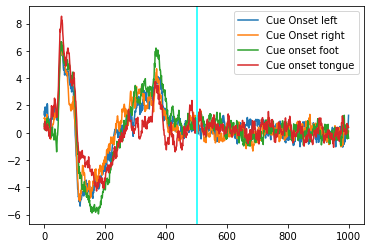

In [13]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769
## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])




In [14]:
def data_prep(X,y,p,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    total_p = None
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    total_p = p

    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    total_p = np.hstack((total_p, p))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        total_p = np.hstack((total_p, p))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y, total_p




In [15]:
## Preprocessing the dataset
X_train_valid_prep,y_train_valid_prep,person_train_valid_prep = data_prep(X_train_valid,y_train_valid,person_train_valid,2,2,True)
X_test_prep,y_test_prep,person_test_prep = data_prep(X_test,y_test,person_test,2,2,True)
stratif_labels = []
for i in range(person_train_valid_prep.shape[0]):
    stratif_labels.append(str(person_train_valid_prep[i].astype('int'))+str(y_train_valid_prep[i]))
print(person_train_valid_prep.shape)
print(X_train_valid_prep.shape)
print('here',y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)

# splitting based on stratified sampling
x_train, x_valid, y_train, y_valid = train_test_split(X_train_valid_prep,y_train_valid_prep,test_size=1500/8460,stratify=stratif_labels,random_state=20)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(8460,)
(8460, 22, 250)
here (8460,)
(1772, 22, 250)
(1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (1500, 4)
Shape of test labels after categorical conversion: (1772, 4)
Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after a

In [78]:
# Building the CNN model using sequential class
crnn_model = Sequential()

# Conv. block 1

crnn_model.add(layers.Conv2D(filters=16, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
crnn_model.add(layers.MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
crnn_model.add(layers.BatchNormalization())
crnn_model.add(layers.Dropout(0.6))

# Conv. block 2
crnn_model.add(layers.Conv2D(filters=32, kernel_size=(10,1), padding='same', activation='elu'))
crnn_model.add(layers.MaxPooling2D(pool_size=(3,1), padding='same'))
crnn_model.add(layers.BatchNormalization())
crnn_model.add(layers.Dropout(0.6))

# Output layer with Softmax activation
crnn_model.add(Reshape((28,32),input_shape=(28,1,32)))
crnn_model.add(layers.TimeDistributed(layers.Flatten())) # Flattens the input
crnn_model.add(layers.Bidirectional(CuDNNGRU(128,return_sequences=True)))
crnn_model.add(layers.Bidirectional(CuDNNGRU(64)))
# crnn_model.add(layers.Bidirectional(CuDNNLSTM(32)))
crnn_model.add(layers.Dropout(0.6))

crnn_model.add(layers.Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
crnn_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 250, 1, 16)        3536      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 84, 1, 16)         0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 84, 1, 16)         64        
_________________________________________________________________
dropout_47 (Dropout)         (None, 84, 1, 16)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 84, 1, 32)         5152      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 28, 1, 32)         0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 28, 1, 32)       

In [79]:
# Model parameters
learning_rate = 1.5e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(learning_rate)

In [80]:
# Compiling the model
crnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
crnn_model_results = crnn_model.fit(x_train,
             y_train,
             batch_size=512,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)




Epoch 1/50
14/14 [==============================] - 4s 92ms/step - loss: 1.4205 - accuracy: 0.2871 - val_loss: 1.3944 - val_accuracy: 0.2960
Epoch 2/50
14/14 [==============================] - 0s 31ms/step - loss: 1.3749 - accuracy: 0.3251 - val_loss: 1.3505 - val_accuracy: 0.3593
Epoch 3/50
14/14 [==============================] - 0s 31ms/step - loss: 1.3256 - accuracy: 0.3621 - val_loss: 1.2518 - val_accuracy: 0.4207
Epoch 4/50
14/14 [==============================] - 0s 33ms/step - loss: 1.2682 - accuracy: 0.4182 - val_loss: 1.2604 - val_accuracy: 0.4353
Epoch 5/50
14/14 [==============================] - 0s 32ms/step - loss: 1.2273 - accuracy: 0.4444 - val_loss: 1.1623 - val_accuracy: 0.5100
Epoch 6/50
14/14 [==============================] - 0s 31ms/step - loss: 1.1980 - accuracy: 0.4672 - val_loss: 1.2460 - val_accuracy: 0.4633
Epoch 7/50
14/14 [==============================] - 0s 28ms/step - loss: 1.1571 - accuracy: 0.4904 - val_loss: 1.0908 - val_accuracy: 0.5613
Epoch 8/50
14

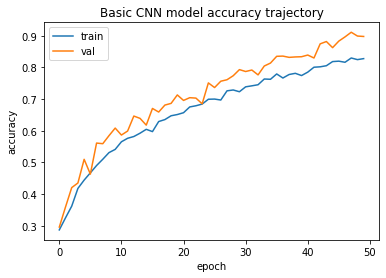

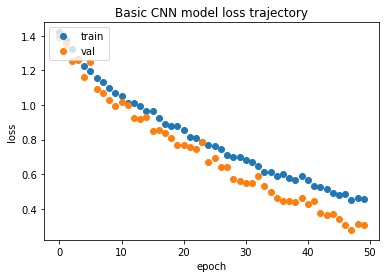

In [81]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(crnn_model_results.history['accuracy'])
plt.plot(crnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(crnn_model_results.history['loss'],'o')
plt.plot(crnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [82]:
## Testing the basic CNN model

cnn_score = crnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.6495485305786133
